## Dense Sequences
This is to check whether the off-line learning rule can learn dense sequences (0000) -> (0001) -> (0011) - > (0111)-> (1111)

In [3]:
import pprint
import subprocess
import sys 
sys.path.append('../')

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.9, 12)

np.set_printoptions(suppress=True, precision=5)

sns.set(font_scale=3.5)

from network import Protocol, NetworkManager, BCPNNPerfect, TimedInput
from connectivity_functions import create_orthogonal_canonical_representation, build_network_representation
from connectivity_functions import get_weights_from_probabilities, get_probabilities_from_network_representation
from analysis_functions import calculate_recall_time_quantities, get_weights
from analysis_functions import get_weights_collections
from plotting_functions import plot_network_activity_angle, plot_weight_matrix

In [4]:
epsilon = 10e-10

## An Example

In [9]:
always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = True
normalized_currents = True

g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.050
tau_z_post_ampa = 0.001
tau_p = 10.0

hypercolumns = 3
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o', 'i_ampa', 'a', 's']

# Protocol
training_time = 0.100
inter_sequence_interval = 0.0
inter_pulse_interval = 0.0
resting_time = 2.0
epochs = 1

# Recall
T_recall = 0.8
n = 1
T_cue = 0.010


matrix = np.array(((0, 0, 0), (1, 1, 1), (2, 2, 2), (3, 3, 3), (4, 4, 4), (5, 5, 5), (6, 6, 6), 
                   (7, 7, 7), (1, 0, 0), (8, 8, 8), (9, 9, 9)))
# matrix = np.array(((0, 0, 0), (1, 1, 1), (2, 2, 2), (3, 3, 3), (1, 0, 0)))
#matrix = np.array(((0, 0, 0), (0, 0, 1), (0, 1, 1), (1, 1, 1)))
# matrix = np.array(((0, 0, 0, 2, 2, 2), (0, 0, 1, 3, 3, 3), (0, 1, 1, 4, 4, 4), (1, 1, 1, 5, 5, 5)))
# matrix = np.array(((0, 0, 0), (0, 0, 1), (2, 2, 2), (3, 3, 3)))
# matrix = np.array(((0, 0, 0), (1, 1, 1), (2, 2, 2), (3, 3, 3)))
network_representation = build_network_representation(matrix, minicolumns, hypercolumns)

timed_input = TimedInput(network_representation, dt, training_time, 
                         inter_pulse_interval=inter_pulse_interval, 
                         inter_sequence_interval=inter_sequence_interval, 
                         epochs=epochs, resting_time=resting_time)

S = timed_input.build_timed_input()
z_pre = timed_input.build_filtered_input_pre(tau_z_pre_ampa)
z_post = timed_input.build_filtered_input_post(tau_z_post_ampa)

pi, pj, P = timed_input.calculate_probabilities_from_time_signal(filtered=True)
w_timed, beta_timed = get_weights_from_probabilities(pi, pj, P, minicolumns, hypercolumns, small_number=epsilon)

In [10]:
network_representation[0]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0])

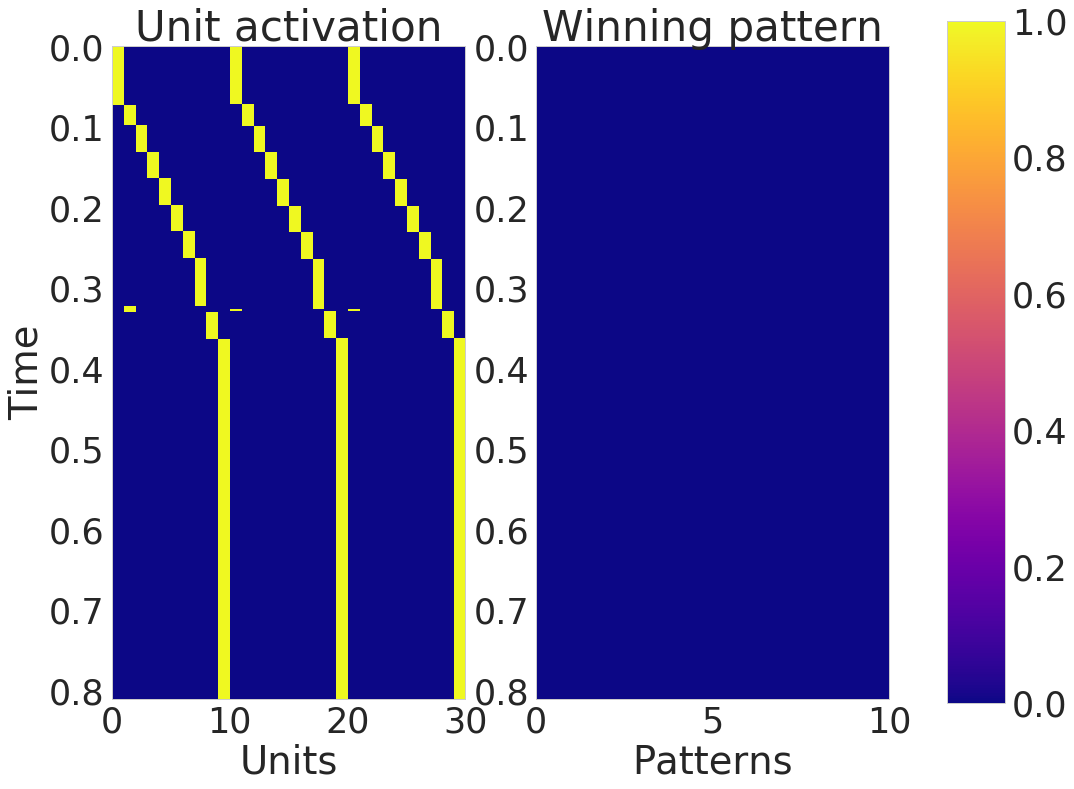

In [11]:
nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m,
                  sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                  z_transfer=z_transfer, diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                  perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                  normalized_currents=normalized_currents)

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Build the protocol for training
nn.w_ampa = w_timed

# Recall
patterns_indexes = [i for i in range(n_patterns)]
sequences = [patterns_indexes]
manager.run_network_recall(T_recall=T_recall, T_cue=T_cue, I_cue=network_representation[0], reset=True, empty_history=False)


plot_network_activity_angle(manager)

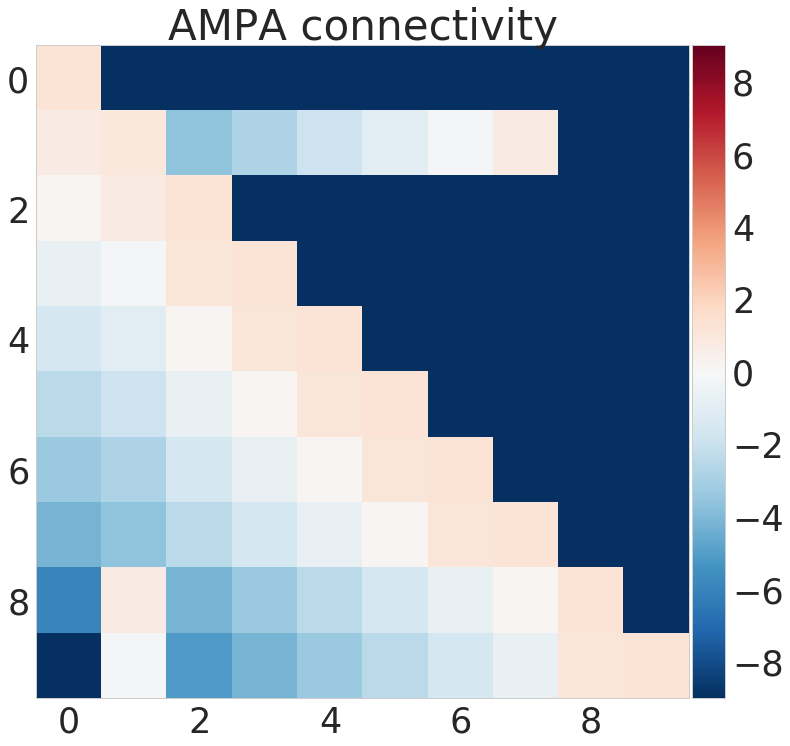

In [12]:
plot_weight_matrix(manager.nn, ampa=True, one_hypercolum=True)

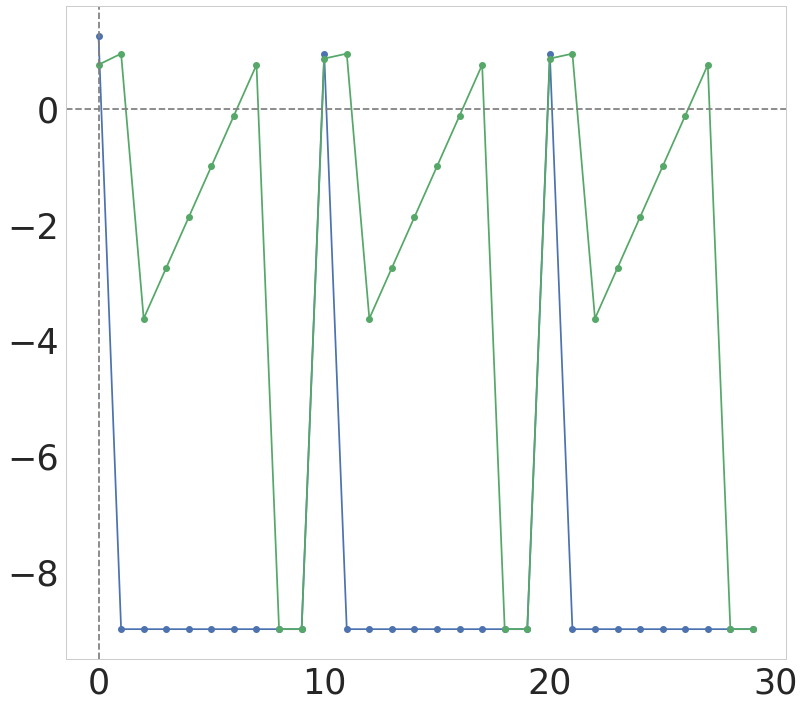

In [12]:
plt.plot(w_timed[0, :], 'o-')
plt.plot(w_timed[1, :], 'o-')
plt.axhline(0, ls='--', color='gray')
plt.axvline(0, ls='--', color='gray')

In [13]:
ampa_current = manager.history['i_ampa']
adaptation = manager.history['a']
s = manager.history['s']
o = manager.history['o']
start = 400
end = 500
total_current0 = ampa_current[start:end, 0] + g_a * adaptation[start:end, 0]
total_current1 = ampa_current[start:end, 0] + g_a * adaptation[start:end, 1]

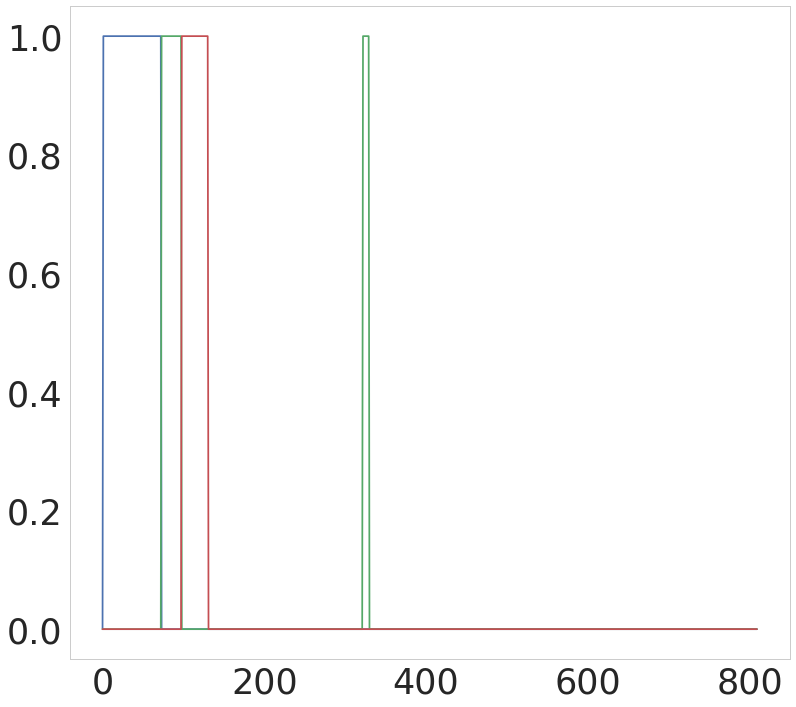

In [14]:
plt.plot(o[:, 0])
plt.plot(o[:, 1])
plt.plot(o[:, 2])

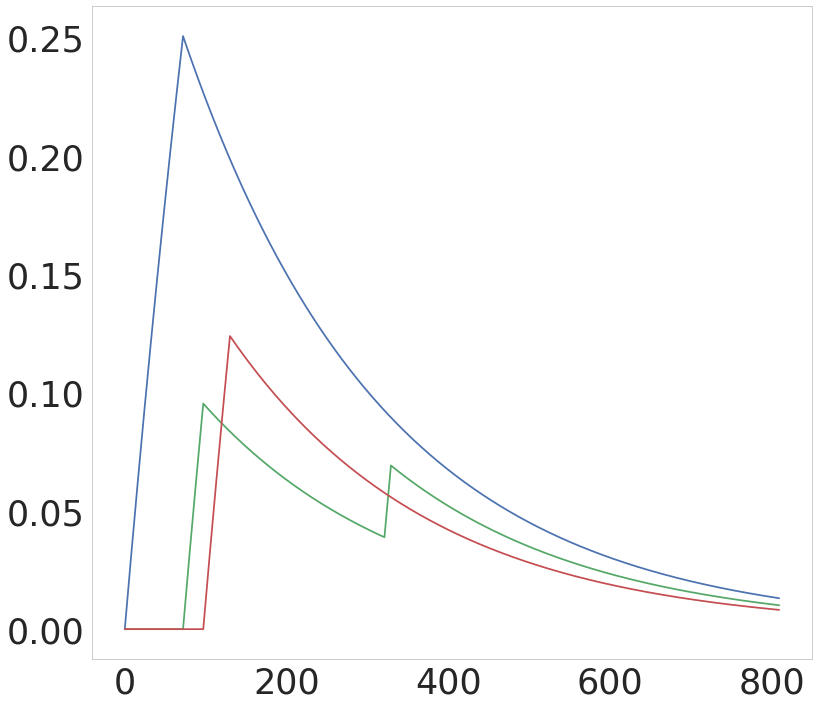

In [15]:
plt.plot(adaptation[:, 0])
plt.plot(adaptation[:, 1])
plt.plot(adaptation[:, 2])

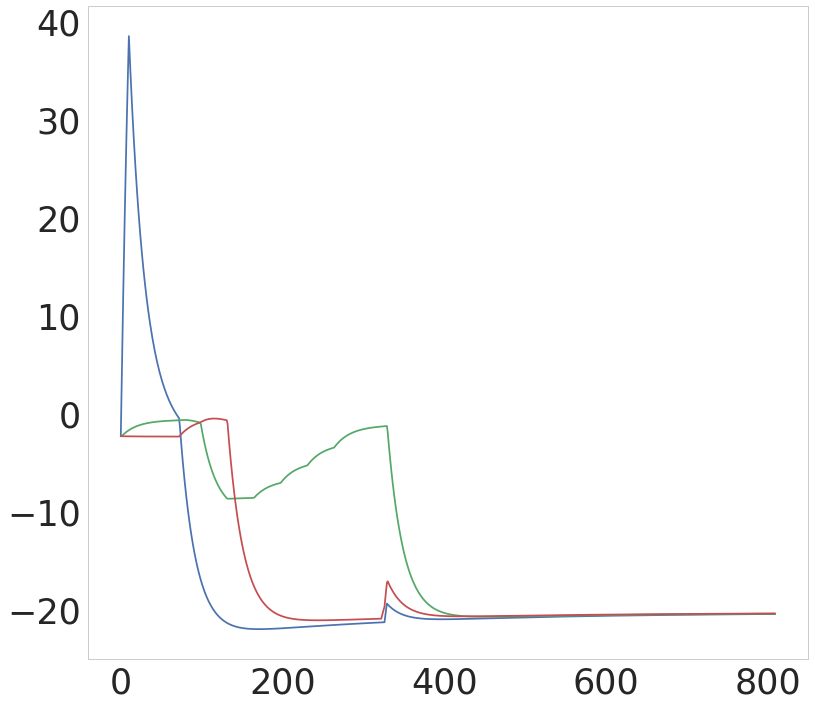

In [16]:
plt.plot(s[:, 0])
plt.plot(s[:, 1])
plt.plot(s[:, 2])

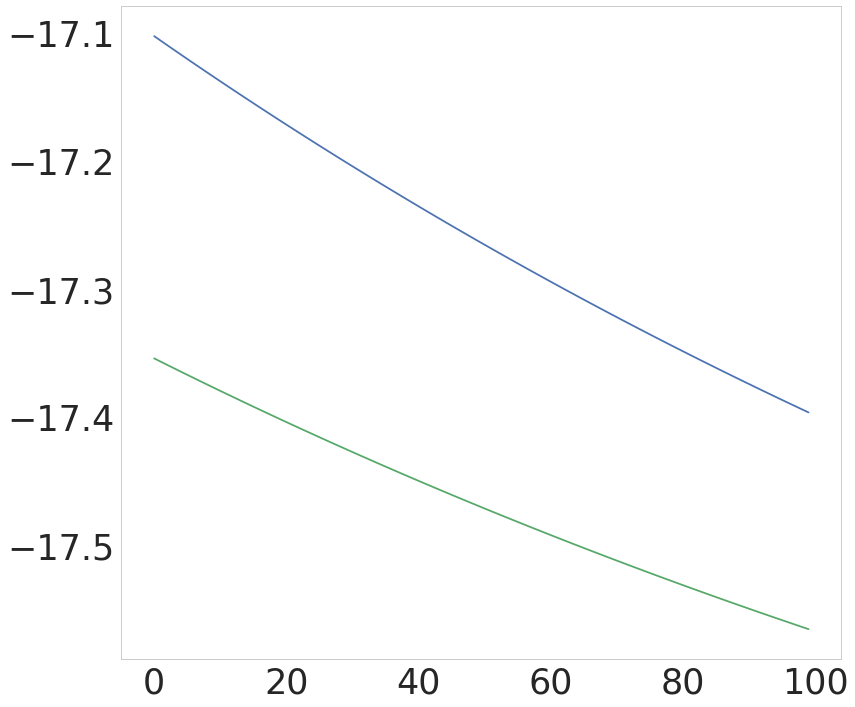

In [59]:
plt.plot(total_current0)
plt.plot(total_current1)

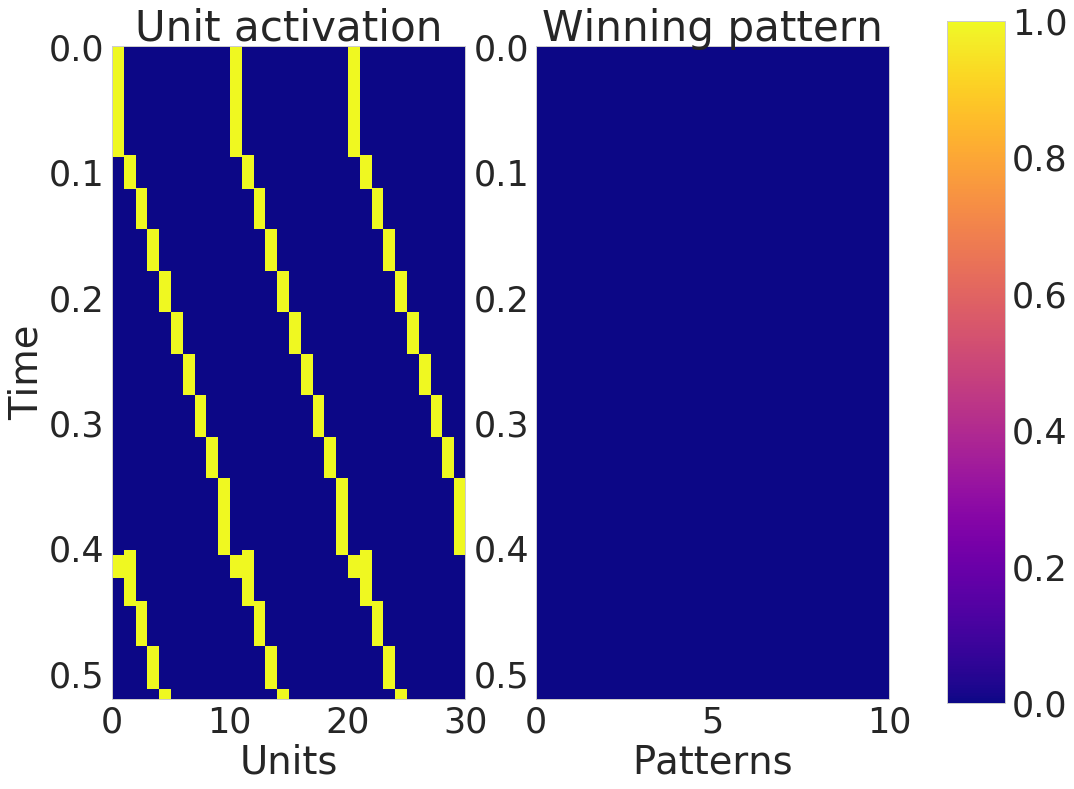

In [167]:
plot_network_activity_angle(manager)

In [170]:
nn.strict_maximum

True

In [37]:
unit = 0
for i in range(hypercolumns):
    print('----')
    print('w', w_timed[minicolumns*i + unit, minicolumns*i + unit])
    print('P', P[minicolumns*i + unit, minicolumns*i + unit])
    print('p', pi[minicolumns*i + unit])
    print('ratio', P[minicolumns*i + unit, minicolumns*i + unit] /(pi[minicolumns*i + unit] * pj[minicolumns*i + unit]))

----
w 1.48633708069
P 0.0307248321876
p 0.0833663454364
ratio 4.42087252606
----
w 1.48633708069
P 0.0307248321876
p 0.0833663454364
ratio 4.42087252606
----
w 1.63365496579
P 0.0089002458561
p 0.0416828430677
ratio 5.12256333836


In [35]:
P

array([[ 0.03072,  0.     ,  0.01038,  0.00629,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  0.     ,  0.03072,  0.     ,
         0.01038,  0.00629,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.01536,  0.01536,  0.01038,  0.00629,
         0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.01038,  0.     ,  0.0089 ,  0.00646,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  0.     ,  0.01038,  0.     ,
         0.0089 ,  0.00646,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.00391,  0.00646,  0.0089 ,  0.00646,
         0.     ,  0.     ,  0.     ,  0.     

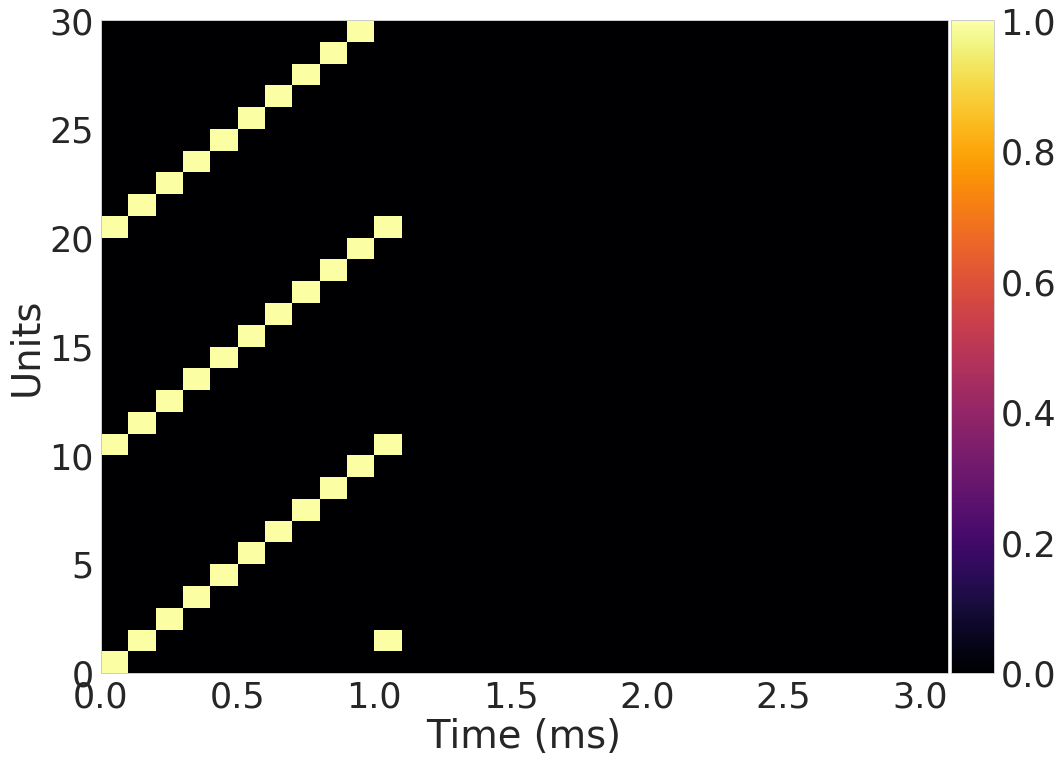

In [53]:
figsize = (16, 12)
cmap = matplotlib.cm.inferno

extent = [0, timed_input.T_total, 0, minicolumns * hypercolumns]

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
im = ax.imshow(S, cmap=cmap, origin='lower', extent=extent, aspect='auto')
ax.grid(0)

ax.set_xlabel('Time (ms)')
ax.set_ylabel('Units')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical');

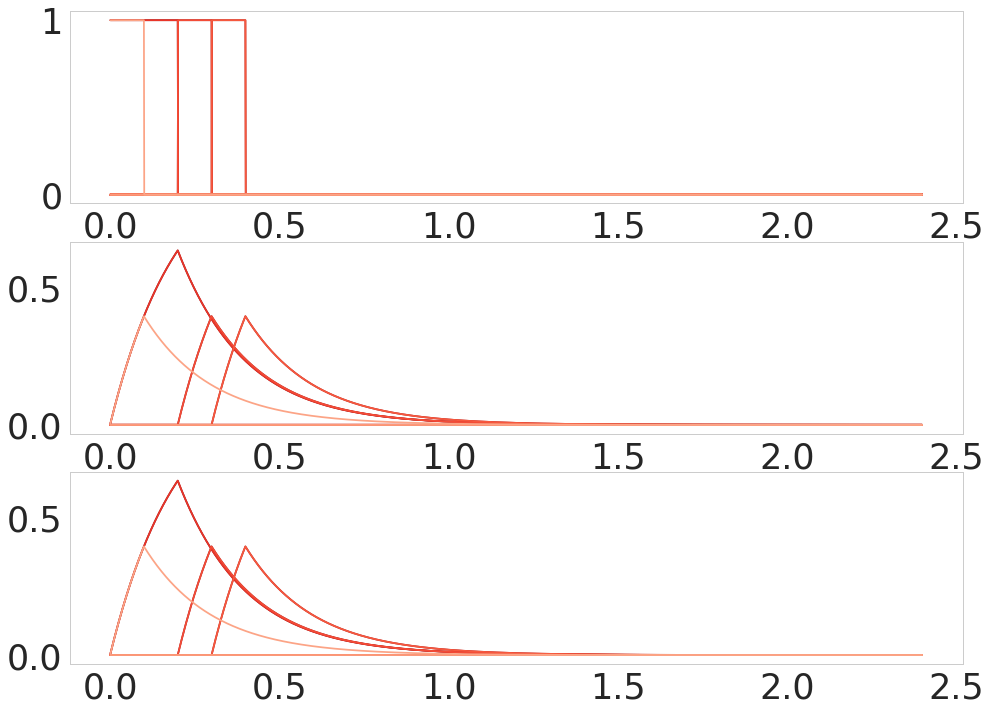

In [30]:
palette = sns.color_palette("Reds_r", S.shape[0])
figsize = (16, 12)
fig = plt.figure(figsize=figsize)
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

for index, s in enumerate(S):
    if index < 21:
        ax1.plot(timed_input.time, s, color=palette[index])
        ax2.plot(timed_input.time, z_pre[index, :], color=palette[index])
        ax3.plot(timed_input.time, z_post[index, :], color=palette[index])